#1   Problem Statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

#2	Solution Steps

2.1.	Data Reading /Data Understanding

2.2.	Dataset Creation

2.3.	Dataset Visualisation

2.4.	Model Building & Training

2.5.	Data Augmentation Strategy

2.6.	Model Building & Training on the Augmented Data

2.7.	Class Distribution

2.8.	Handling Class Imbalances

2.9.	Model Building & Training on the rectified Class Imbalance Data

2.10  Outcome Summary

## 2.1.	Data Reading/Data Understanding 

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import google

In [2]:
#mounting google drive where images are stored
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


<!-- This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively. -->

In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")


In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [ ]:
#### Loading Dataset using keras.preprocessing
#### Loading these images off disk using the helpful image_dataset_from_directory utility.

## 2.2.	Dataset Creation

##### Defining parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180   

#### Using 80% of the images for training, and 20% for validation.

In [6]:
#### Writing train dataset
#### Using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
#### Resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split= 0.2,
    subset= 'training',
    seed=123,
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [7]:
#### Writing validation dataset
#### Using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
#### Resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory (
    data_dir_train,
    validation_split= 0.2,
    subset= 'validation',
    seed=123,
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [8]:
# Listing out all the classes of skin cancer and storing them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 2.3.	Dataset Visualisation:

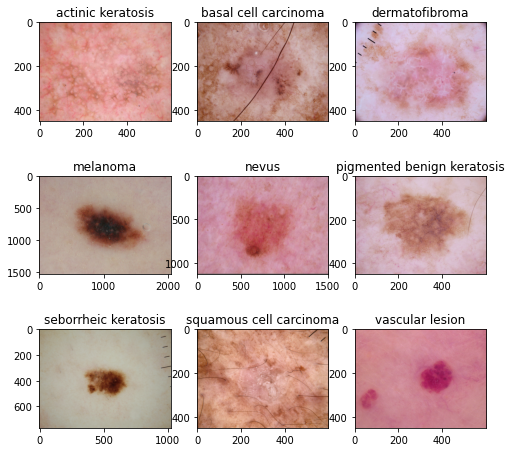

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img

#### Visualizing one instance of all the nine classes present in the dataset

plt.figure(figsize=(8,8))
for i in range (len(class_names)):
  plt.subplot(3,3, i+1)
  if len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))) > 0:
    image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
    plt.title(class_names[i])
    plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 2.4.	Model Building & Training:

#### Creating the model
Creating a CNN model, which can accurately detect 9 classes present in the dataset.

Using layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Standardizing values to be in the `[0, 1]`

In [ ]:
# CNN Model

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = len(class_names)

# scaling the pixel values from 0-255 to 0-1
# Convolution layer with 16/32/64 features, 3x3 filter and relu activation with 2x2 pooling
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
#### Compiling the model with adam optimizer and Sparse loss function for model training 
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#### Viewing the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 64800)            

In [ ]:
#### Training the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 83s 1s/step - loss: 2.3182 - accuracy: 0.2673 - val_loss: 1.7676 - val_accuracy: 0.4206
Epoch 2/20
56/56 [==============================] - 61s 1s/step - loss: 1.7766 - accuracy: 0.3761 - val_loss: 1.7926 - val_accuracy: 0.3490
Epoch 3/20
56/56 [==============================] - 56s 992ms/step - loss: 1.6479 - accuracy: 0.4102 - val_loss: 1.5673 - val_accuracy: 0.4743
Epoch 4/20
56/56 [==============================] - 54s 963ms/step - loss: 1.5521 - accuracy: 0.4738 - val_loss: 1.5565 - val_accuracy: 0.4698
Epoch 5/20
56/56 [==============================] - 61s 1s/step - loss: 1.4926 - accuracy: 0.4799 - val_loss: 1.4793 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 57s 1s/step - loss: 1.4232 - accuracy: 0.4927 - val_loss: 1.4686 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 57s 1s/step - loss: 1.3335 - accuracy: 0.5352 - val_loss: 1.5776 - val_accuracy: 0.4787
Epoch 8/20
56/

#### Visualizing training results

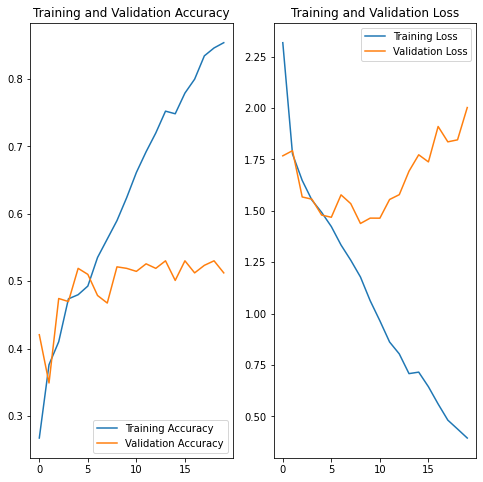

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit

(1) Big difference between training accuracy and validation accuracy; when 80%+ training accuracy then validation accuracy is just ~50%. It is clearly overfitting.

(2) Training error rate is trending down along with validation error rate for initial epochs but later validation error is increasing 

(3) Lets leverage data augmentation to overcome overfitting problem during training.

(4) Data augmentation will expose the model to more aspects of the data and the model can be generalized. 

## 2.5.	Data Augmentation Strategy:

In [9]:
### Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
### Your code goes here

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
   ]
)

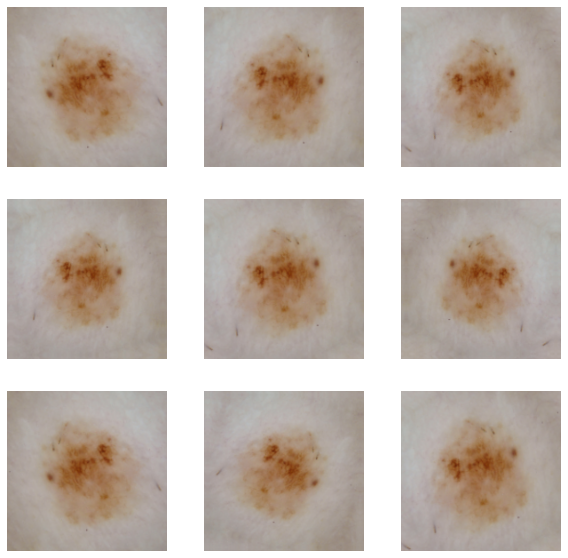

In [ ]:
### Visualizing how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(10):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## 2.6.	Model Building & Training on the Augmented Data:

In [ ]:
# CNN model

# scaling the pixel values from 0-255 to 0-1
# Convolution layer with 16/32/64 features, 3x3 filter and relu activation with 2x2 pooling
model = Sequential([data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(len(class_names), activation = 'softmax' )
])

### Compiling the model

In [ ]:
### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
### Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20


56/56 [==============================] - 73s 1s/step - loss: 2.4472 - accuracy: 0.1914 - val_loss: 1.9997 - val_accuracy: 0.2595
Epoch 2/20
56/56 [==============================] - 80s 1s/step - loss: 1.9366 - accuracy: 0.2952 - val_loss: 1.8959 - val_accuracy: 0.2573
Epoch 3/20
56/56 [==============================] - 73s 1s/step - loss: 1.8268 - accuracy: 0.3175 - val_loss: 1.8873 - val_accuracy: 0.4139
Epoch 4/20
56/56 [==============================] - 75s 1s/step - loss: 1.7207 - accuracy: 0.4018 - val_loss: 1.5845 - val_accuracy: 0.4519
Epoch 5/20
56/56 [==============================] - 74s 1s/step - loss: 1.5764 - accuracy: 0.4453 - val_loss: 1.5933 - val_accuracy: 0.4787
Epoch 6/20
56/56 [==============================] - 71s 1s/step - loss: 1.4929 - accuracy: 0.4877 - val_loss: 1.4797 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 80s 1s/step - loss: 1.4528 - accuracy: 0.4967 - val_loss: 1.4424 - val_accuracy: 0.5280
Epoch 8/20
56/56 [=============

### Visualizing the results

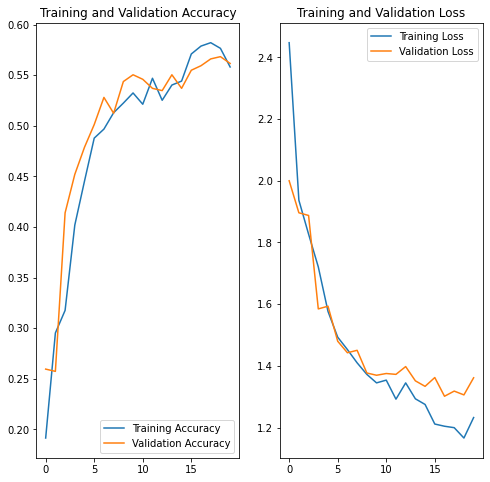

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings:

Yes. There is imporvement. Overfitting problem is resolved which was observed in the previous model. 

In this model, marginal difference in training (approx 60%) and validation accuracy ( approx 50%). But accuracy score is not yet optimal and need to improve 

## 2.7.	Class Distribution: 

#### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
#### Finding number of samples across classes

cols = ['Label', 'Count']
lst = []

for i in range(len(class_names)):
    a = class_names[i] + '/*'
    cnt = len(list(data_dir_train.glob(a))) # image_count_train
    lst.append([class_names[i], cnt])
original_df = pd.DataFrame(lst, columns=cols)
original_df.sort_values(by='Count', axis=0, ascending=False, inplace=True)
original_df

Label  Count
5  pigmented benign keratosis    462
3                    melanoma    438
1        basal cell carcinoma    376
4                       nevus    357
7     squamous cell carcinoma    181
8             vascular lesion    139
0           actinic keratosis    114
2              dermatofibroma     95
6        seborrheic keratosis     77

#### Findings: 
Q: Which class has the least number of samples?

A: Class 'seborrheic keratosis' is with least number of samples as 77

Q: Which classes dominate the data in terms proportionate number of samples?

A: Classes 'pigmented benign keratosis' & 'melanoma' with number of samples as 462 & 438 respectively, these classes dominate the data in terms proportionate number of samples.

## 2.8.	Handling Class Imbalances: 

In [ ]:
#### Rectifying class imbalances using augmentor

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiating a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Defining a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Executing these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset= "/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2A70E0BBB0>: 100%|██████████| 500/500 [00:32<00:00, 15.52 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2A6FF52A60>: 100%|██████████| 500/500 [00:26<00:00, 18.99 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2A70139AF0>: 100%|██████████| 500/500 [00:31<00:00, 15.93 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2A6445FA60>: 100%|██████████| 500/500 [02:24<00:00,  3.45 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2117x1988 at 0x7F2A7077DF10>: 100%|██████████| 500/500 [02:02<00:00,  4.08 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2A7008ED90>: 100%|██████████| 500/500 [00:30<00:00, 16.57 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2A710D9D30>: 100%|██████████| 500/500 [01:02<00:00,  7.95 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2A64303C40>: 100%|██████████| 500/500 [00:30<00:00, 16.16 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2A7114C7F0>: 100%|██████████| 500/500 [00:28<00:00, 17.28 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types

Taking a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### Checking the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_084a4a1e-e069-49fb-8714-c18ec18b9f20.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026525.jpg_6f4ddf91-a771-43ce-a866-cc2530959008.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026149.jpg_15b0ff12-6f9e-435f-9e96-b09cd76e1033.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027580.jpg_8222c9cf-1493-43e1-b3fa-212120dde82b.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029827.jpg_be88bd89

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    501
melanoma                      501
basal cell carcinoma          501
nevus                         501
squamous cell carcinoma       501
vascular lesion               501
actinic keratosis             501
dermatofibroma                501
seborrheic keratosis          501
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class 

## 2.9    Model Building & Training on the rectified Class Imbalance Data:

#### Training the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [ ]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating a model by including normalization

In [10]:

# CCN Model, scaling the pixel values from 0-255 to 0-1
model = Sequential([data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

   # Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  #adding a 20% dropout after the convolution layers
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(len(class_names), activation = 'softmax' )
])



#### Compiling the model 

In [11]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

#### Training the model

In [12]:
epochs = 30
## Your code goes here, use 30 epochs.
# history = # your model fit code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


169/169 [==============================] - 1324s 8s/step - loss: 2.7392 - accuracy: 0.1907 - val_loss: 1.9693 - val_accuracy: 0.2339
Epoch 2/30
169/169 [==============================] - 1166s 7s/step - loss: 1.7457 - accuracy: 0.3500 - val_loss: 1.4888 - val_accuracy: 0.4246
Epoch 3/30
169/169 [==============================] - 1124s 7s/step - loss: 1.4666 - accuracy: 0.4342 - val_loss: 1.4219 - val_accuracy: 0.4425
Epoch 4/30
169/169 [==============================] - 1102s 7s/step - loss: 1.3698 - accuracy: 0.4790 - val_loss: 1.3107 - val_accuracy: 0.4967
Epoch 5/30
169/169 [==============================] - 1198s 7s/step - loss: 1.2990 - accuracy: 0.5057 - val_loss: 1.3435 - val_accuracy: 0.4952
Epoch 6/30
169/169 [==============================] - 1233s 7s/step - loss: 1.2262 - accuracy: 0.5376 - val_loss: 1.1657 - val_accuracy: 0.5702
Epoch 7/30
169/169 [==============================] - 1099s 7s/step - loss: 1.1193 - accuracy: 0.5861 - val_loss: 1.1140 - val_accuracy: 0.5865
Epo

#### Visualizing the model results

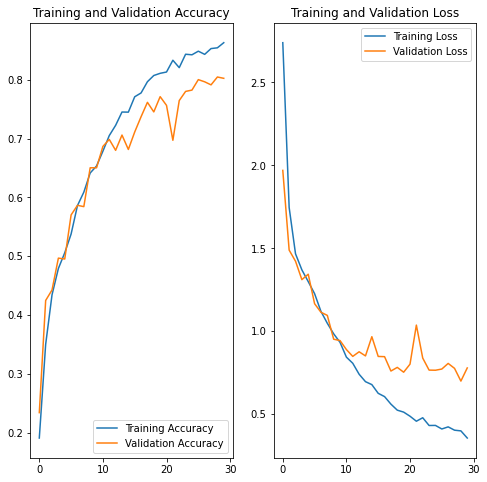

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyzing the results


## 2.10    Outcome Summary

1) The class imbalance issue is rectified by adding image data using augmentor. Now, the validation accuracy also increases along with training accuracy.

2) The training as well as validation loss decreases with epochs.

3)The gap between training accuracy and validation accuracy decreased significantly from the previous model along with improved accurancy score.

4)Addtional features added in the convplutional layer to improve accuracy further 

5)Data Augmentation helped to address overfitting problem; make the model generalized and class rebalancing improved the accuracy from ~55% of previous model to ~80% in the model.

## END